In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from matplotlib import pyplot as plt

#path = os.getcwd()
#path = path.replace("/ipython_notebooks","")
path = "/home/alex/inter_simulation_results/hsmc_harvard/normal_mix_results"
os.chdir(path)
model_name = 'normal_mix'
names_files_list = os.listdir(path)
print(names_files_list)


/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


['normal_mix_normal_mix_all_dict_sampler_dim_50.p', 'normal_mix_normal_mix_all_dict_sampler_dim_100.p', 'normal_mix_normal_mix_all_dict_sampler_dim_10.p', 'normal_mix_normal_mix_all_dict_sampler_dim_20.p']


In [6]:
# workaround for pickle and pandas error
import sys
# 1
import pandas.core.indexes 
sys.modules['pandas.indexes'] = pandas.core.indexes
# 2
import pandas.core.base, pandas.core.indexes.frozen
setattr(sys.modules['pandas.core.base'],'FrozenNDArray', pandas.core.indexes.frozen.FrozenNDArray)


In [5]:
pd.__version__
pickle.__version__
#mh_res = pickle.load(file=open('%s_%s_all_dict_sampler_dim_10.p' %(model_name, model_name), "rb")) 

'$Revision: 72223 $'

In [7]:
#dimensions = [2, 5, 10, 20, 31, 50, 100]
dimensions = [10, 20, 50, 100]
means_list = []
vars_list = []
norms_list = []
computation_list = []
zero_one_list = []

for dim in dimensions:
    mh_res = pickle.load(file=open('%s_%s_all_dict_sampler_dim_%s.p' %(model_name, model_name, dim), "rb"))
    if False: 
        is_res = pickle.load(file=open('%s_%s_all_dict_is_sampler_dim_%s.p'%(model_name, model_name, dim), "rb"))

        res_all_norm = np.vstack((mh_res['norm_const'], is_res['norm_const']))
        res_all_mean = np.vstack((mh_res['mean_array'], is_res['mean_array']))
        res_all_var = np.vstack((mh_res['var_array'], is_res['var_array']))
        
    else: 
        res_all_norm = mh_res['norm_const']
        res_all_mean = mh_res['mean_array']
        res_all_var = mh_res['var_array']
        res_all_computation = (mh_res['temp_steps']*mh_res['L_mean']).mean(axis=1)

    computation_list.append(res_all_computation)
    if model_name == 'normal':
        vars_list.append( res_all_computation*np.nanmean((res_all_var-mh_res['parameters']['targetvariance'])**2, axis=1).sum(axis=1).sum(axis=1))
        means_list.append(res_all_computation*np.nanmean((res_all_mean-mh_res['parameters']['targetmean'])**2, axis=1).sum(axis=1))
        norms_list.append(res_all_computation*np.nanmean((res_all_norm)**2, axis=1))  
    elif model_name == 'student':
        scale_factor_variance = mh_res['parameters']['df']/(mh_res['parameters']['df']-2)
        vars_list.append( res_all_computation*np.nanmean((res_all_var-scale_factor_variance*mh_res['parameters']['targetvariance'])**2, axis=1).sum(axis=1).sum(axis=1))
        means_list.append(res_all_computation*np.nanmean((res_all_mean-mh_res['parameters']['targetmean'])**2, axis=1).sum(axis=1))
        norms_list.append(res_all_computation*np.nanmean((res_all_norm)**2, axis=1))
    #elif model_name == 'logistic': 
    else: 
        vars_list.append( res_all_computation*np.nanvar(res_all_var, axis=1).sum(axis=1).sum(axis=1))
        means_list.append(res_all_computation*np.nanvar(res_all_mean, axis=1).sum(axis=1))
        norms_list.append(res_all_computation*np.nanvar(res_all_norm, axis=1))
    
    if model_name == 'normal_mix':
        res = (((mh_res['particles_array']<0).mean(axis=0).mean(axis=0)-0.5)**2).mean(axis=1)*res_all_computation
        zero_one_list.append(res)


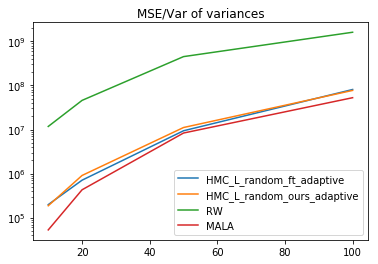

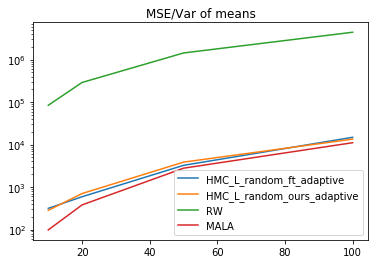

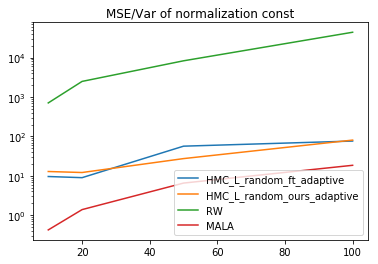

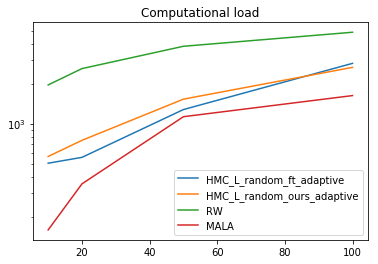

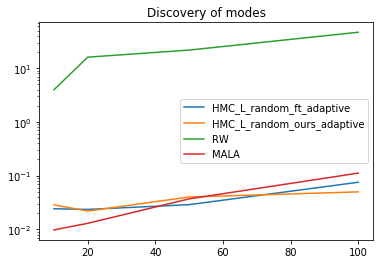

In [8]:
#sampler_labels =  mh_res['names_samplers']+is_res['names_samplers']
sampler_labels =  mh_res['names_samplers']
plt.title('MSE/Var of variances')
for i, name in enumerate(sampler_labels):
    plt.plot(dimensions, np.array(vars_list)[:,i], label = name)
plt.yscale('log')
plt.legend()
plt.savefig("mse_variances_%s.png" % model_name)
plt.show()

plt.title('MSE/Var of means')
for i, name in enumerate(sampler_labels):
    plt.plot(dimensions, np.array(means_list)[:,i], label = name)
plt.yscale('log')
plt.legend()
plt.savefig("mse_means_%s.png" % model_name)
plt.show()

plt.title('MSE/Var of normalization const')
for i, name in enumerate(sampler_labels):
    plt.plot(dimensions, np.array(norms_list)[:,i], label = name)
plt.yscale('log')
plt.legend()
plt.savefig("mse_norm_const_%s.png" % model_name)
plt.show()

plt.title('Computational load')
for i, name in enumerate(sampler_labels):
    plt.plot(dimensions, np.array(computation_list)[:,i], label = name)
plt.yscale('log')
plt.legend()
plt.savefig("computational_load_%s.png" % model_name)

plt.show()

if model_name == 'normal_mix':
    plt.title('Discovery of modes')
    for i, name in enumerate(sampler_labels):
        plt.plot(dimensions, np.array(zero_one_list)[:,i], label = name)
    plt.yscale('log')
    plt.legend()
    plt.savefig("zero_one_estimation_%s.png" % model_name)
    plt.show()